In [1]:
!nvidia-smi

Sun Dec 17 10:49:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning
!pip install --quiet peft
!pip install --quiet sentencepiece
!pip install --quiet datasets
!pip install --quiet accelerate
!pip install --quiet bitsandbytes
!pip install --quiet openpyxl
!pip install --quiet evaluate
#!pip install --quiet numpy==1.23.1

In [3]:
import json
import pandas as pd
import numpy as np
from transformers import BitsAndBytesConfig
from pathlib import Path
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
train_path = '/kaggle/input/bias-of-us-news-media-houses/Train.xlsx'

In [5]:
df = pd.read_excel(train_path,engine='openpyxl')

In [6]:
df.head(3)

,Unnamed: 0,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID
0,0,immigration,National Review,2,https://www.nationalreview.com/2018/12/governm...,"Shutdown Theater, Again",2018-12-12,"Kevin D. Williamson, Kyle Smith, Andrew C. Mcc...",President Trump and Senate Minority Leader Chu...,President Trump and Senate Minority Leader Chu...,www.nationalreview.com,right,zl7kc7EmAyIdUMIo
1,1,culture,Yahoo! The 360,1,https://news.yahoo.com/can-the-developing-worl...,Can the developing world endure the coronavirus?,2020-06-30,Mike Bebernes,“ The 360 ” shows you diverse perspectives on ...,“The 360” shows you diverse perspectives on th...,www.news.yahoo.com,center,xpbjYTJYPdlw6HmJ
2,2,elections,Politico,0,http://www.politico.com/story/2016/07/bernie-s...,Sanders’ California supporters can’t quite say...,2016-07-02,"Daniel Strauss, Henry C. Jackson, Nick Gass",LOS ANGELES — Actress Rosario Dawson took the ...,LOS ANGELES — Actress Rosario Dawson took the ...,www.politico.com,left,k4SGI3GXarnz5dJl


In [7]:
df = df.iloc[:5000]

In [8]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

## **FLAN-T5 large**

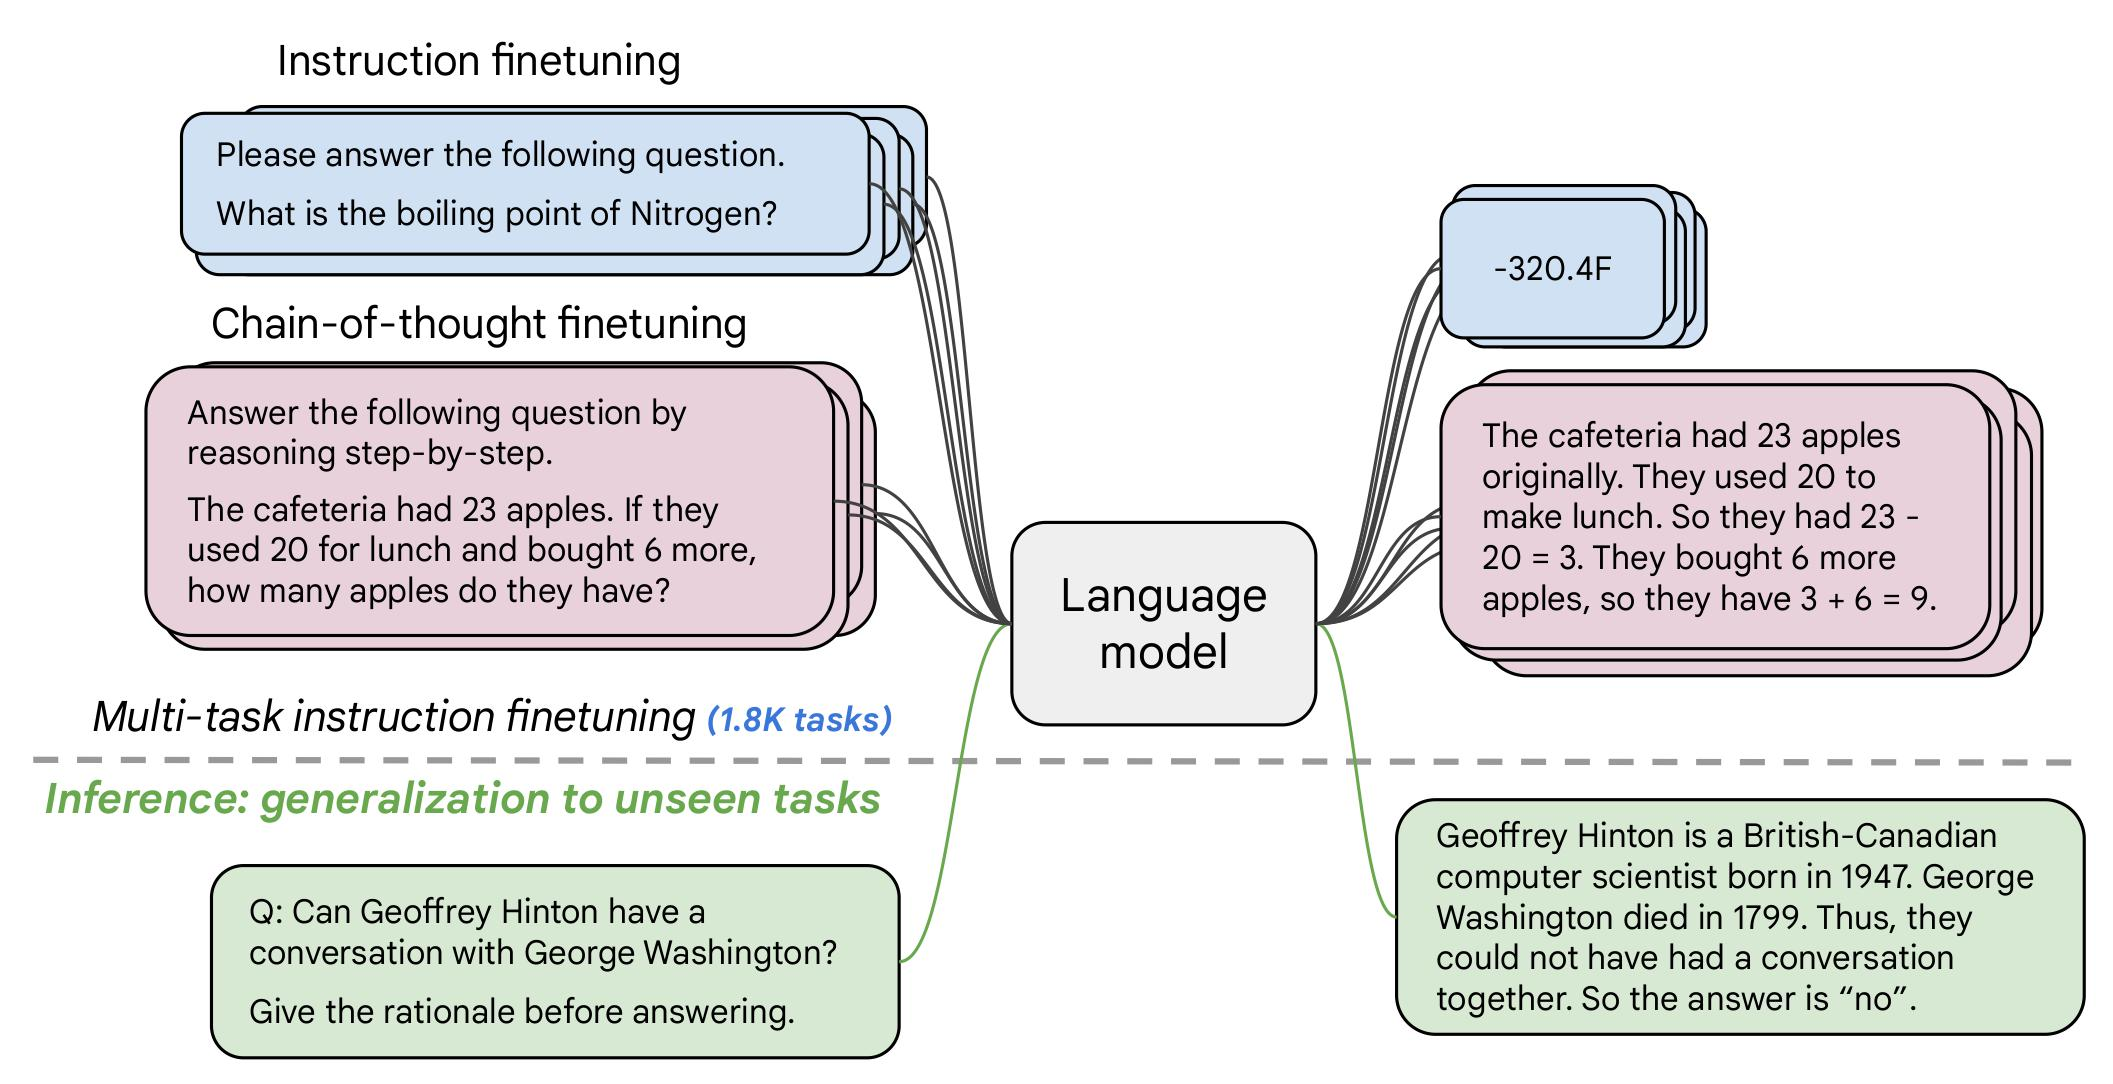

### **Model size : 783M params**

In [9]:
MODEL_NAME = "google/flan-t5-large"

In [10]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [11]:
#tokenizer.add_special_tokens({'pad_token': '0'})

In [12]:
bias_label_dict = {'left': 0, 'center': 1, 'right': 2}
df['label'] = df['bias_text'].map(bias_label_dict)

In [13]:
df["label"].astype(int)

0       2
1       1
2       0
3       1
4       0
       ..
4995    2
4996    0
4997    1
4998    0
4999    1
Name: label, Length: 5000, dtype: int64

In [14]:
train_df, val_df = train_test_split(df,test_size=0.1)

In [15]:
class BiasDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.data = df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        content = str(self.data.iloc[idx]['content'])
        bias_label = self.data.iloc[idx]['label']

        inputs = self.tokenizer(
            content,
            truncation=True,
            return_tensors='pt')


        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'label': bias_label
        }

In [16]:
train_dataset = BiasDataset(train_df, tokenizer)
val_dataset = BiasDataset(val_df, tokenizer)


In [17]:
# Accessing a sample
sample = val_dataset[0]
print(sample)

{'input_ids': tensor([ 2523,  4983,  5185,   272, 11863, 11046,  6728,   938,  5034, 12330,
            7,    86, 13394,     3,     6, 10271, 10768,     7,   227,     3,
            9,  2822,  5191,    16, 13394,  4683,     3,     9, 12404,  7234,
            3,    60,     7, 13023,   455,   581,  1661,  2523,     3,    31,
            7,  1111,  4514,     3,     6,   412,     5,   134,     5,  3570,
         2243, 12330,    37,  7512,    15,   309,     5, 16636,  1468,     3,
            6,    16, 10271,     3,     6,  4683,     3,     9, 12404, 17413,
           16,  6959,  4985, 19551,    53,     8,  7961,    13,     8,  2777,
           18,  1135,  4514,   581, 15111,    45,  7449,     3,     6, 24533,
            3,     6, 26991,     9,     3,     6, 21986,     3,     6, 11380,
           11, 27796,     3,     5, 16636,  1468,     3,    31,     7,   455,
          177,   725,     8, 16877,     7,     3,    31,  1690,    12,  2463,
          119,  1467,    13,  2523,     3,    31, 

In [18]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [19]:
import evaluate

accuracy = evaluate.load("accuracy")

In [20]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [21]:
id2label = {0: "left", 1: "center", 2: "right"}
label2id = {"left": 0, "center": 1, "right" : 2}

In [22]:
import torch

In [23]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

In [24]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,
                                                           num_labels=3,
                                                           id2label=id2label,
                                                           label2id=label2id,
                                                           quantization_config=quantization_config)
                                                           

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google/flan-t5-large and are newly initialized: ['classification_head.out_proj.bias', 'classification_head.out_proj.weight', 'classification_head.dense.weight', 'classification_head.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from peft import LoraConfig, get_peft_model, TaskType


In [26]:

config = LoraConfig(
    r=8, #attention heads
    lora_alpha=16, #alpha scaling
    target_modules=["q", "k", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS
)
  

In [27]:
model = get_peft_model(model, config)


In [28]:
model.print_trainable_parameters()

trainable params: 3,538,944 || all params: 754,842,627 || trainable%: 0.4688320284805537


**trainable params: 3,538,944 
all params: 754,842,627 
trainable%: 0.4688320284805537**


In [29]:
import torch

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [31]:
import transformers

In [32]:
training_args = transformers.TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

In [33]:
trainer = transformers.Trainer(
    model=model.to(device),
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=data_collator,
   # compute_metrics=compute_metrics,
)

In [34]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.000000,nan
2,0.000000,nan
3,0.000000,nan
4,0.000000,nan


TrainOutput(global_step=9000, training_loss=0.021201171875, metrics={'train_runtime': 9120.4817, 'train_samples_per_second': 1.974, 'train_steps_per_second': 0.987, 'total_flos': 3.9919511923552104e+16, 'train_loss': 0.021201171875, 'epoch': 4.0})

In [35]:
trainer.state.log_history

[{'loss': 0.3816,
  'learning_rate': 1.888888888888889e-05,
  'epoch': 0.22,
  'step': 500},
 {'loss': 0.0,
  'learning_rate': 1.7777777777777777e-05,
  'epoch': 0.44,
  'step': 1000},
 {'loss': 0.0,
  'learning_rate': 1.6666666666666667e-05,
  'epoch': 0.67,
  'step': 1500},
 {'loss': 0.0,
  'learning_rate': 1.555555555555556e-05,
  'epoch': 0.89,
  'step': 2000},
 {'eval_loss': nan,
  'eval_runtime': 100.1036,
  'eval_samples_per_second': 4.995,
  'eval_steps_per_second': 2.497,
  'epoch': 1.0,
  'step': 2250},
 {'loss': 0.0,
  'learning_rate': 1.4444444444444446e-05,
  'epoch': 1.11,
  'step': 2500},
 {'loss': 0.0,
  'learning_rate': 1.3333333333333333e-05,
  'epoch': 1.33,
  'step': 3000},
 {'loss': 0.0,
  'learning_rate': 1.2222222222222224e-05,
  'epoch': 1.56,
  'step': 3500},
 {'loss': 0.0,
  'learning_rate': 1.1111111111111113e-05,
  'epoch': 1.78,
  'step': 4000},
 {'loss': 0.0, 'learning_rate': 1e-05, 'epoch': 2.0, 'step': 4500},
 {'eval_loss': nan,
  'eval_runtime': 100.124

In [36]:
def predict_bias(idx):
  print("\n\nACTUAL : ",val_df.iloc[idx]['bias_text'])

  inputs = tokenizer(val_df.iloc[idx]['content'],truncation=True,return_tensors="pt").to(device)

  model.eval()

  with torch.no_grad():
    logits = model(**inputs).logits

  predicted_class_id = logits.argmax().item()
  print("\n\n\nPREDICTED BIAS : ",model.config.id2label[predicted_class_id])


In [37]:
predict_bias(5)



ACTUAL :  left



PREDICTED BIAS :  left
